# Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import statsmodels.api as sm
import seaborn as sn
import gmaps
import json
from scipy.stats import sem,chisquare
from scipy.stats import linregress
from api_keys import g_key

# Import Google Maps API Key

In [2]:
gmaps.configure(api_key=g_key)

# Import Crime Data

In [3]:
filepath = "Resources/AnyConv.com__Crime_Incidents_in_2017.csv"
df = pd.read_csv(filepath, low_memory=False)

df.head(3)

CCN,C,80           REPORT_DAT,C,80 SHIFT,C,80 METHOD,C,80  OFFENSE,C,80  \
0   2111617  2017-02-06T20:11:14.000Z    EVENING      OTHERS   THEFT/OTHER   
1   7093973  2017-06-03T12:54:27.000Z        DAY      OTHERS  THEFT F/AUTO   
2  17400847  2017-05-25T13:07:34.000Z        DAY      OTHERS  THEFT F/AUTO   

                                  BLOCK,C,80  XBLOCK,N,10,0  YBLOCK,N,10,0  \
0      600 - 669 BLOCK OF MARYLAND AVENUE NE         400212         136281   
1           2900 - 2999 BLOCK OF N STREET NW         394912         137666   
2  4500 - 4599 BLOCK OF BRANDYWINE STREET NW         392231         142425   

   WARD,C,80 ANC,C,80  ...  BLOCK_GROU,C,80  CENSUS_TRA,C,80 VOTING_PRE,C,80  \
0          6       6C  ...         008302 1           8302.0     Precinct 84   
1          2       2E  ...         000100 4            100.0      Precinct 5   
2          3       3E  ...         001001 3           1001.0     Precinct 31   

  LATITUDE,N,24,15  LONGITUDE,N,24,15      BID,C,80           START_DATE,C,80  \
0        38.894376         -76.997556  CAPITOL HILL  2017-02-01T11:55:55.000Z   
1        38.906838         -77.058661           NaN  2017-06-03T11:54:03.000Z   
2        38.949689         -77.089625           NaN  2017-05-12T23:00:00.000Z   

              END_DATE,C,80 OBJECTID,N,10,0 OCTO_RECOR,C,80  
0                       NaN       306952475     02111617-01  
1  2017-06-03T11:55:05.000Z       306952489     07093973-01  
2  2017-05-13T09:00:00.000Z       306951085     17400847-01  

[3 rows x 23 columns]

# Rename Columns

- remove punctuation from column names
- create more user-friendly names

In [4]:
df.columns

Index(['CCN,C,80', 'REPORT_DAT,C,80', 'SHIFT,C,80', 'METHOD,C,80',
       'OFFENSE,C,80', 'BLOCK,C,80', 'XBLOCK,N,10,0', 'YBLOCK,N,10,0',
       'WARD,C,80', 'ANC,C,80', 'DISTRICT,C,80', 'PSA,C,80', 'NEIGHBORHO,C,80',
       'BLOCK_GROU,C,80', 'CENSUS_TRA,C,80', 'VOTING_PRE,C,80',
       'LATITUDE,N,24,15', 'LONGITUDE,N,24,15', 'BID,C,80', 'START_DATE,C,80',
       'END_DATE,C,80', 'OBJECTID,N,10,0', 'OCTO_RECOR,C,80'],
      dtype='object')

In [5]:
renamed_df = df.rename(columns={'CCN,C,80':'CCN', 'REPORT_DAT,C,80':'Report', 'SHIFT,C,80':'Shift', 
                                'METHOD,C,80':'Method', 'OFFENSE,C,80':'Offense', 'BLOCK,C,80':'Block',
                                'XBLOCK,N,10,0':'XBlock', 'YBLOCK,N,10,0':'YBlock','WARD,C,80':'Ward',
                                'ANC,C,80':'ANC', 'DISTRICT,C,80':'District', 'PSA,C,80':'PSA', 
                                'NEIGHBORHO,C,80':'Neighborhood','BLOCK_GROU,C,80':'Block_Grou', 
                                'CENSUS_TRA,C,80':'Census_Trac', 'VOTING_PRE,C,80':'Voting_Precinct',
                                'LATITUDE,N,24,15':'Latitude', 'LONGITUDE,N,24,15':'Longitude', 
                                'BID,C,80':'Bid', 'START_DATE,C,80':'Start_Date','END_DATE,C,80':'End_Date',
                                'OBJECTID,N,10,0':'Object_ID', 'OCTO_RECOR,C,80':'Octo_Recor' })
renamed_df.columns

Index(['CCN', 'Report', 'Shift', 'Method', 'Offense', 'Block', 'XBlock',
       'YBlock', 'Ward', 'ANC', 'District', 'PSA', 'Neighborhood',
       'Block_Grou', 'Census_Trac', 'Voting_Precinct', 'Latitude', 'Longitude',
       'Bid', 'Start_Date', 'End_Date', 'Object_ID', 'Octo_Recor'],
      dtype='object')

# Find Null Values

### Identify Columns with NaN

In [6]:
count_nan_in_df = renamed_df.isnull().sum()
#print (count_nan_in_df)
count_nan_in_df

CCN                    0
Report                 0
Shift                  0
Method                 0
Offense                0
Block                  0
XBlock                 0
YBlock                 0
Ward                   0
ANC                    0
District               3
PSA                    3
Neighborhood         370
Block_Grou            84
Census_Trac           84
Voting_Precinct        0
Latitude               0
Longitude              0
Bid                27252
Start_Date             0
End_Date            1497
Object_ID              0
Octo_Recor             0
dtype: int64

### Dropped Bid column

- was not being used

In [7]:
renamed_df.drop('Bid', axis=1, inplace=True)

### PSA column: Isolate Rows with NULL value

In [8]:
mask = renamed_df['PSA'].isnull()
renamed_df.loc[mask]

CCN                    Report    Shift  Method       Offense  \
184  17401844  2017-11-01T18:06:16.000Z  EVENING  OTHERS  THEFT F/AUTO   
185  17401847  2017-11-14T10:46:23.000Z      DAY  OTHERS   THEFT/OTHER   
186  17401849  2017-11-04T08:06:19.000Z      DAY  OTHERS   THEFT/OTHER   

                                           Block  XBlock  YBlock  Ward ANC  \
184  1700 - 1717 BLOCK OF CONSTITUTION AVENUE NE  401707  136018     6  6A   
185             2400 - 2499 BLOCK OF M STREET NW  395459  137490     2  2A   
186             1600 - 1699 BLOCK OF P STREET NW  396746  137976     2  2B   

     ...  Neighborhood  Block_Grou Census_Trac Voting_Precinct   Latitude  \
184  ...    Cluster 26    008002 1      8002.0     Precinct 86  38.892005   
185  ...     Cluster 5    005500 2      5500.0      Precinct 4  38.905255   
186  ...     Cluster 6    005301 3      5301.0     Precinct 15  38.909639   

     Longitude                Start_Date                  End_Date  Object_ID  \
184 -76.980324  2017-11-01T16:00:00.000Z  2017-11-01T16:05:00.000Z  306951319   
185 -77.052353  2017-10-29T10:30:00.000Z  2017-11-11T18:30:00.000Z  306951320   
186 -77.037518  2017-11-01T08:00:00.000Z  2017-11-02T17:00:00.000Z  306951321   

      Octo_Recor  
184  17401844-01  
185  17401847-01  
186  17401849-01  

[3 rows x 22 columns]

### PSA column: Fill NaN with Median Value

In [9]:
renamed_df['PSA'] = renamed_df['PSA'].fillna(renamed_df['PSA'].median())

In [10]:
renamed_df['District'] = renamed_df['District'].fillna(renamed_df['District'].median())

In [11]:
renamed_df['Neighborhood'] = renamed_df['Neighborhood'].fillna('Cluster 9')

In [12]:
renamed_df['Census_Trac'] = renamed_df['Census_Trac'].fillna(renamed_df['Census_Trac'].median())

In [13]:
renamed_df['Block_Grou'] = renamed_df['Block_Grou'].fillna('011100')

In [14]:
renamed_df['End_Date'] = renamed_df['End_Date'].fillna('2018-01-21 17:20:59+0000')

In [15]:
renamed_df.isnull().sum()

CCN                0
Report             0
Shift              0
Method             0
Offense            0
Block              0
XBlock             0
YBlock             0
Ward               0
ANC                0
District           0
PSA                0
Neighborhood       0
Block_Grou         0
Census_Trac        0
Voting_Precinct    0
Latitude           0
Longitude          0
Start_Date         0
End_Date           0
Object_ID          0
Octo_Recor         0
dtype: int64

In [16]:
renamed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33082 entries, 0 to 33081
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CCN              33082 non-null  int64  
 1   Report           33082 non-null  object 
 2   Shift            33082 non-null  object 
 3   Method           33082 non-null  object 
 4   Offense          33082 non-null  object 
 5   Block            33082 non-null  object 
 6   XBlock           33082 non-null  int64  
 7   YBlock           33082 non-null  int64  
 8   Ward             33082 non-null  int64  
 9   ANC              33082 non-null  object 
 10  District         33082 non-null  float64
 11  PSA              33082 non-null  float64
 12  Neighborhood     33082 non-null  object 
 13  Block_Grou       33082 non-null  object 
 14  Census_Trac      33082 non-null  float64
 15  Voting_Precinct  33082 non-null  object 
 16  Latitude         33082 non-null  float64
 17  Longitude   

# Convert Date Columns to Date Type

In [17]:
renamed_df['Start_Date'] = pd.to_datetime(renamed_df['Start_Date'], format='%Y-%m-%dT%H:%M:%S.%f')

In [18]:
renamed_df['End_Date'] = pd.to_datetime(renamed_df['End_Date'], format='%Y-%m-%dT%H:%M:%S.%f')

### Confirm Columns are now Timestamps

In [19]:
renamed_df['Start_Date'][1]

Timestamp('2017-06-03 11:54:03+0000', tz='UTC')

In [20]:
renamed_df['End_Date'][1]

Timestamp('2017-06-03 11:55:05+0000', tz='UTC')

# Convert Census_Trac Column to String

In [21]:
renamed_df['Census_Trac'] = renamed_df['Census_Trac'].astype(str)
type(renamed_df['Census_Trac'][1])

str

# Plot TimeSeries Of Crime

### Set 'Start_Date' as the Index 

In [22]:
date_df = renamed_df
date_df.sort_values('Start_Date', ascending=False, inplace=True)
date_df.set_index('Start_Date', inplace=True)

In [23]:
date_df.index.max()

Timestamp('2017-12-31 21:47:23+0000', tz='UTC')

In [24]:
date_df.index.min()

Timestamp('1980-06-02 20:00:46+0000', tz='UTC')

In [25]:
date_df.index.unique()

DatetimeIndex(['2017-12-31 21:47:23+00:00', '2017-12-31 19:44:06+00:00',
               '2017-12-31 18:50:04+00:00', '2017-12-31 17:18:18+00:00',
               '2017-12-31 17:06:21+00:00', '2017-12-31 16:59:27+00:00',
               '2017-12-31 16:10:06+00:00', '2017-12-31 15:56:09+00:00',
               '2017-12-31 15:05:07+00:00', '2017-12-31 14:30:46+00:00',
               ...
               '2012-03-29 11:02:37+00:00', '2010-11-27 15:00:00+00:00',
               '2010-11-26 03:00:08+00:00', '2010-07-27 21:00:23+00:00',
               '2010-05-01 20:21:06+00:00', '2009-02-13 12:03:45+00:00',
               '2009-01-17 00:00:55+00:00', '2007-03-21 15:52:49+00:00',
               '2007-03-01 12:00:03+00:00', '1980-06-02 20:00:46+00:00'],
              dtype='datetime64[ns, UTC]', name='Start_Date', length=32919, freq=None)

In [26]:
date_df.head()

CCN                    Report    Shift  \
Start_Date                                                               
2017-12-31 21:47:23+00:00  17224414  2017-12-31T22:57:01.000Z  EVENING   
2017-12-31 19:44:06+00:00  17224392  2017-12-31T21:54:00.000Z  EVENING   
2017-12-31 18:50:04+00:00  17224331  2017-12-31T19:48:08.000Z  EVENING   
2017-12-31 17:18:18+00:00  17224289  2017-12-31T17:50:36.000Z  EVENING   
2017-12-31 17:06:21+00:00  17224286  2017-12-31T17:57:14.000Z  EVENING   

                           Method                     Offense  \
Start_Date                                                      
2017-12-31 21:47:23+00:00     GUN  ASSAULT W/DANGEROUS WEAPON   
2017-12-31 19:44:06+00:00     GUN  ASSAULT W/DANGEROUS WEAPON   
2017-12-31 18:50:04+00:00  OTHERS                THEFT F/AUTO   
2017-12-31 17:18:18+00:00  OTHERS                 THEFT/OTHER   
2017-12-31 17:06:21+00:00  OTHERS                 THEFT/OTHER   

                                                            Block  XBlock  \
Start_Date                                                                  
2017-12-31 21:47:23+00:00  4412 4499  BLOCK OF SOUTHERN AVENUE SE  405682   
2017-12-31 19:44:06+00:00      600 - 699 BLOCK OF NEWTON PLACE NW  398007   
2017-12-31 18:50:04+00:00        3100 - 3199 BLOCK OF K STREET NW  394626   
2017-12-31 17:18:18+00:00    3100 - 3299 BLOCK OF ADAMS STREET NE  403249   
2017-12-31 17:06:21+00:00   4600 - 4699 BLOCK OF HILLSIDE ROAD SE  405846   

                           YBlock  Ward ANC  ...    PSA  Neighborhood  \
Start_Date                                   ...                        
2017-12-31 21:47:23+00:00  133941     7  7E  ...  605.0    Cluster 33   
2017-12-31 19:44:06+00:00  140667     1  1A  ...  409.0     Cluster 2   
2017-12-31 18:50:04+00:00  137194     2  2E  ...  206.0     Cluster 4   
2017-12-31 17:18:18+00:00  139270     5  5C  ...  503.0    Cluster 24   
2017-12-31 17:06:21+00:00  134296     7  7E  ...  604.0    Cluster 33   

                          Block_Grou Census_Trac Voting_Precinct   Latitude  \
Start_Date                                                                    
2017-12-31 21:47:23+00:00   007707 2      7707.0    Precinct 106  38.873278   
2017-12-31 19:44:06+00:00   003200 2      3200.0     Precinct 43  38.933884   
2017-12-31 18:50:04+00:00   000100 4       100.0      Precinct 5  38.902584   
2017-12-31 17:18:18+00:00   011100 1     11100.0     Precinct 71  38.921296   
2017-12-31 17:06:21+00:00   007707 1      7707.0    Precinct 106  38.876475   

                           Longitude                  End_Date  Object_ID  \
Start_Date                                                                  
2017-12-31 21:47:23+00:00 -76.934521 2017-12-31 22:57:01+00:00  306951076   
2017-12-31 19:44:06+00:00 -77.022987 2017-12-31 21:53:58+00:00  306951074   
2017-12-31 18:50:04+00:00 -77.061955 2017-12-31 19:35:41+00:00  306951071   
2017-12-31 17:18:18+00:00 -76.962534 2017-12-31 17:50:34+00:00  306951069   
2017-12-31 17:06:21+00:00 -76.932628 2017-12-31 17:40:29+00:00  306951068   

                            Octo_Recor  
Start_Date                              
2017-12-31 21:47:23+00:00  17224414-01  
2017-12-31 19:44:06+00:00  17224392-01  
2017-12-31 18:50:04+00:00  17224331-01  
2017-12-31 17:18:18+00:00  17224289-01  
2017-12-31 17:06:21+00:00  17224286-01  

[5 rows x 21 columns]

In [27]:
date_agg_df = date_df.groupby('Start_Date').count()
date_agg_df.head(1)

CCN  Report  Shift  Method  Offense  Block  XBlock  \
Start_Date                                                                      
1980-06-02 20:00:46+00:00    1       1      1       1        1      1       1   

                           YBlock  Ward  ANC  ...  PSA  Neighborhood  \
Start_Date                                    ...                      
1980-06-02 20:00:46+00:00       1     1    1  ...    1             1   

                           Block_Grou  Census_Trac  Voting_Precinct  Latitude  \
Start_Date                                                                      
1980-06-02 20:00:46+00:00           1            1                1         1   

                           Longitude  End_Date  Object_ID  Octo_Recor  
Start_Date                                                             
1980-06-02 20:00:46+00:00          1         1          1           1  

[1 rows x 21 columns]

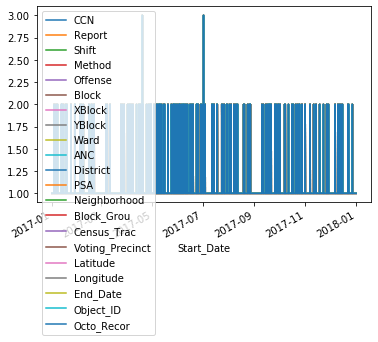

In [28]:
date_agg_df["2017-01-01":"2017-12-31"].plot();

### Dataset covers 1980 - 2017

- not only 2017

In [29]:
date_df.index.year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2012, 2010, 2010, 2010, 2010, 2009, 2009, 2007, 2007, 1980],
           dtype='int64', name='Start_Date', length=33082)

In [30]:
date_df.head(3)

CCN                    Report    Shift  \
Start_Date                                                               
2017-12-31 21:47:23+00:00  17224414  2017-12-31T22:57:01.000Z  EVENING   
2017-12-31 19:44:06+00:00  17224392  2017-12-31T21:54:00.000Z  EVENING   
2017-12-31 18:50:04+00:00  17224331  2017-12-31T19:48:08.000Z  EVENING   

                           Method                     Offense  \
Start_Date                                                      
2017-12-31 21:47:23+00:00     GUN  ASSAULT W/DANGEROUS WEAPON   
2017-12-31 19:44:06+00:00     GUN  ASSAULT W/DANGEROUS WEAPON   
2017-12-31 18:50:04+00:00  OTHERS                THEFT F/AUTO   

                                                            Block  XBlock  \
Start_Date                                                                  
2017-12-31 21:47:23+00:00  4412 4499  BLOCK OF SOUTHERN AVENUE SE  405682   
2017-12-31 19:44:06+00:00      600 - 699 BLOCK OF NEWTON PLACE NW  398007   
2017-12-31 18:50:04+00:00        3100 - 3199 BLOCK OF K STREET NW  394626   

                           YBlock  Ward ANC  ...    PSA  Neighborhood  \
Start_Date                                   ...                        
2017-12-31 21:47:23+00:00  133941     7  7E  ...  605.0    Cluster 33   
2017-12-31 19:44:06+00:00  140667     1  1A  ...  409.0     Cluster 2   
2017-12-31 18:50:04+00:00  137194     2  2E  ...  206.0     Cluster 4   

                          Block_Grou Census_Trac Voting_Precinct   Latitude  \
Start_Date                                                                    
2017-12-31 21:47:23+00:00   007707 2      7707.0    Precinct 106  38.873278   
2017-12-31 19:44:06+00:00   003200 2      3200.0     Precinct 43  38.933884   
2017-12-31 18:50:04+00:00   000100 4       100.0      Precinct 5  38.902584   

                           Longitude                  End_Date  Object_ID  \
Start_Date                                                                  
2017-12-31 21:47:23+00:00 -76.934521 2017-12-31 22:57:01+00:00  306951076   
2017-12-31 19:44:06+00:00 -77.022987 2017-12-31 21:53:58+00:00  306951074   
2017-12-31 18:50:04+00:00 -77.061955 2017-12-31 19:35:41+00:00  306951071   

                            Octo_Recor  
Start_Date                              
2017-12-31 21:47:23+00:00  17224414-01  
2017-12-31 19:44:06+00:00  17224392-01  
2017-12-31 18:50:04+00:00  17224331-01  

[3 rows x 21 columns]

# Write Modified DataFrame to CSV

- new CSV file will be merged with Washington 2017 Poverty Dataset

In [31]:
renamed_df.to_csv("renamed_crime_data.csv", index=False)

# Overview of Data

In [32]:
renamed_df.describe()

CCN         XBlock         YBlock          Ward      District  \
count  3.308200e+04   33082.000000   33082.000000  33082.000000  33082.000000   
mean   1.712021e+07  399396.652711  137623.379451      4.456139      3.721329   
std    1.502723e+05    3150.374167    3358.194998      2.335491      1.909376   
min    2.111617e+06  390262.000000  127300.000000      1.000000      1.000000   
25%    1.705836e+07  397302.250000  136093.000000      2.000000      2.000000   
50%    1.711666e+07  399074.000000  137579.000000      5.000000      3.000000   
75%    1.717467e+07  401342.250000  139586.000000      6.000000      5.000000   
max    2.709178e+07  407806.000000  147292.000000      8.000000      7.000000   

                PSA      Latitude     Longitude     Object_ID  
count  33082.000000  33082.000000  33082.000000  3.308200e+04  
mean     376.865244     38.906463    -77.006963  3.072805e+08  
std      190.723370      0.030251      0.036323  6.578455e+04  
min      101.000000     38.813471    -77.112316  3.069501e+08  
25%      207.000000     38.892672    -77.031103  3.072732e+08  
50%      308.000000     38.906061    -77.010676  3.072815e+08  
75%      507.000000     38.924144    -76.984522  3.073028e+08  
max      708.000000     38.993560    -76.910021  3.073348e+08

In [33]:
renamed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33082 entries, 2017-12-31 21:47:23+00:00 to 1980-06-02 20:00:46+00:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   CCN              33082 non-null  int64              
 1   Report           33082 non-null  object             
 2   Shift            33082 non-null  object             
 3   Method           33082 non-null  object             
 4   Offense          33082 non-null  object             
 5   Block            33082 non-null  object             
 6   XBlock           33082 non-null  int64              
 7   YBlock           33082 non-null  int64              
 8   Ward             33082 non-null  int64              
 9   ANC              33082 non-null  object             
 10  District         33082 non-null  float64            
 11  PSA              33082 non-null  float64            
 12  Neighborhood     33082 non-

- 33082 rows total
- following rows are missing data
- DISTRICT,C,80
- PSA,C,80
- NEIGHBORHO,C,80
- BLOCK_GROU,C,80
- CENSUS_TRA,C,80
- BID,C,80
- END_DATE,C,80

# Create Google Map of Crime

### Create Heatmap based on Crime by Census Tract

- Aggregate Crime Statistics by Census Tract, Latitude & Longitude

In [34]:
maps_df = renamed_df.groupby(['Census_Trac', 'Latitude', 'Longitude']).count()['CCN']
maps_df = pd.DataFrame(maps_df)
maps_df.reset_index(inplace=True)
maps_df.head()

Census_Trac   Latitude  Longitude  CCN
0       100.0  38.902550 -77.058577    4
1       100.0  38.902584 -77.061955   27
2       100.0  38.902585 -77.059614   19
3       100.0  38.902594 -77.060629   20
4       100.0  38.903008 -77.061137    2

In [35]:
locations = maps_df[['Latitude','Longitude']]

num_of_crimes = maps_df.CCN

figure_layout = {
    'width': '950px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

fig = gmaps.figure(map_type="HYBRID", layout=figure_layout)
heat_layer = gmaps.heatmap_layer(locations, weights=num_of_crimes, dissipating=True)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

# Types of Offenses

- Here is a list of the various types of crime.

In [36]:
renamed_df.Offense.unique()

array(['ASSAULT W/DANGEROUS WEAPON', 'THEFT F/AUTO', 'THEFT/OTHER',
       'MOTOR VEHICLE THEFT', 'ROBBERY', 'SEX ABUSE', 'BURGLARY',
       'HOMICIDE', 'ARSON'], dtype=object)

### Volume of Crime by Type

In [37]:
offense_type = renamed_df.groupby(['Offense']).count()['CCN']
offense_type = pd.DataFrame(offense_type)
offense_type.sort_values('CCN', ascending=False, inplace=True)
offense_type = offense_type.rename(columns={'CCN': 'Frequency in 2017'})
offense_type.index.names = ['Type of Crime']
offense_type

Frequency in 2017
Type of Crime                                
THEFT/OTHER                             14445
THEFT F/AUTO                            10259
MOTOR VEHICLE THEFT                      2408
ROBBERY                                  2170
ASSAULT W/DANGEROUS WEAPON               1856
BURGLARY                                 1531
SEX ABUSE                                 293
HOMICIDE                                  115
ARSON                                       5

# Pie Chart: Types of Weapon

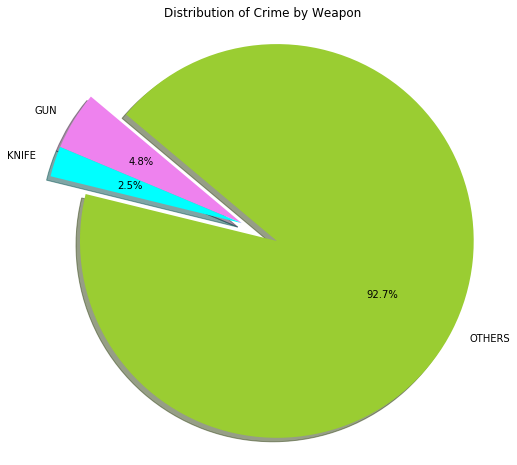

In [38]:
labels = ['GUN', 'KNIFE', 'OTHERS']
sizes = renamed_df.groupby(['Method'])["CCN"].count()
colors = ["violet", "aqua", "yellowgreen"]
explode = (0, 0, 0.2)

plt.figure(figsize=(8, 8))
plt.title("Distribution of Crime by Weapon")
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.axis("equal")
plt.savefig('Images/Pie_Chart_Type_of_Weapon.png')
plt.show()

# Histograms

### Create Function to Plot Histogram

In [39]:
def matplotHistogram(col, df):

    #Plot Bar Chart
    plt.figure(figsize=(8, 8))
    plt.hist(df[col], 100, color='indigo', alpha=0.75)
    #plt.xticks(rotation=90)
    plt.title(f"Washington Crime Statistics 2017 by {col}", fontsize=16, fontweight="bold")
    plt.xlabel(f"{col}")
    plt.ylabel("Frequency of Offences")
    axes = plt.gca()
    axes.yaxis.grid()
    plt.savefig(f'Images/Histogram_{col}.png')
    plt.show()

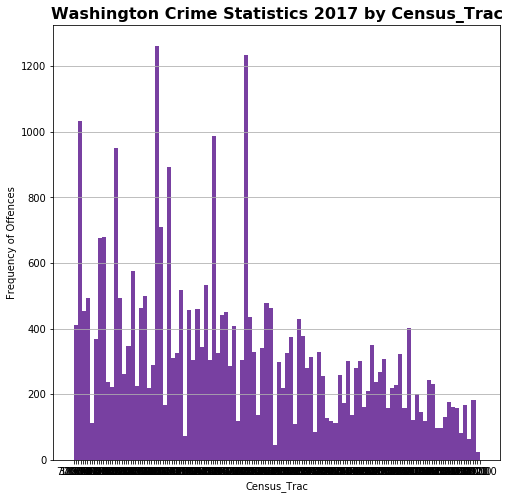

In [40]:
matplotHistogram('Census_Trac', renamed_df)

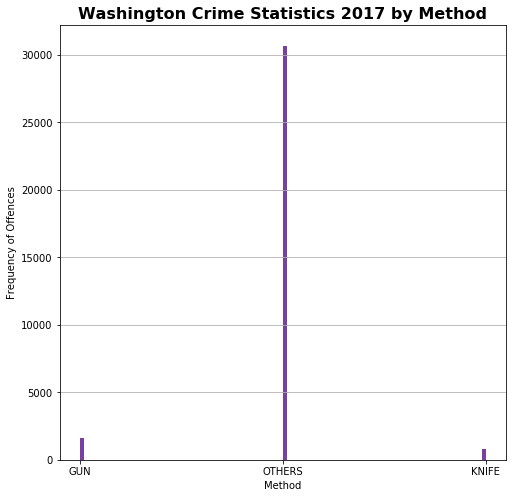

In [41]:
matplotHistogram('Method', renamed_df)

In [42]:
renamed_df.columns

Index(['CCN', 'Report', 'Shift', 'Method', 'Offense', 'Block', 'XBlock',
       'YBlock', 'Ward', 'ANC', 'District', 'PSA', 'Neighborhood',
       'Block_Grou', 'Census_Trac', 'Voting_Precinct', 'Latitude', 'Longitude',
       'End_Date', 'Object_ID', 'Octo_Recor'],
      dtype='object')

### Create Histograms for Each Column

In [43]:
cols = ['Report', 'Shift', 'Method', 'Offense', 'Block', 'XBlock',
       'YBlock', 'Ward', 'ANC', 'District', 'PSA', 'Neighborhood',
       'Block_Grou', 'Census_Trac', 'Voting_Precinct', 'Latitude', 
        'Longitude', 'Object_ID', 'Octo_Recor']

- Graphs indicate that none of these variable demonstrate a normal distribution 

In [44]:
#for col in cols:
#    matplotHistogram(col,renamed_df)

# Bar Charts

### Create Function to Plot Bar Chart

In [45]:
def matplotBarChart(col, df):
    #Groupby operation on Target Column
    #Assign to temporarily DataFrame
    #Sort & capture top 10
    sub_df = df.groupby([col]).count()['CCN']
    sub_df = pd.DataFrame(sub_df)
    sub_df.sort_values('CCN', ascending=False, inplace=True)
    sub_df = sub_df.head(10)

    #Plot Bar Chart
    plt.figure(figsize=(8, 8))
    plt.bar(sub_df.index, sub_df['CCN'], color='indigo', align="center")
    plt.xticks(rotation=90)
    plt.title(f"Washington Crime Statistics 2017 by {col}", fontsize=16, fontweight="bold")
    plt.xlabel(f"{col}")
    plt.ylabel("Number of Offences")
    axes = plt.gca()
    axes.yaxis.grid()
    plt.savefig(f'Images/Bar_Chart_{col}.png')
    plt.show

### Crime by Type of Offense

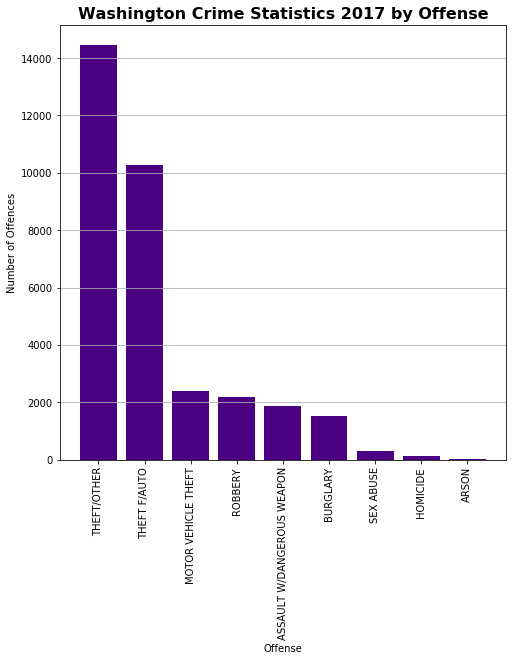

In [46]:
matplotBarChart('Offense', renamed_df)

### Crime by Census Tract

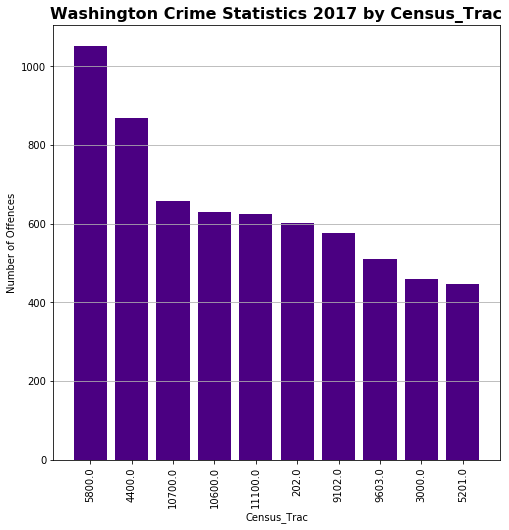

In [47]:
matplotBarChart('Census_Trac', renamed_df)

# Crime by Weapon

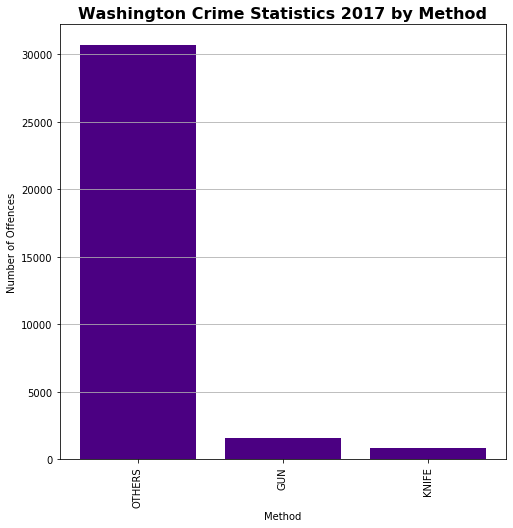

In [48]:
matplotBarChart('Method', renamed_df)

# Correlation

Many of the fields in this dataset were related to location (e.g. XBlock, Ward,Census Tract, Voting Precinct, Latitude, Longitude).
Consequently, it was difficult to find meaningful correlations.

In [49]:
renamed_df.corr()

CCN    XBlock    YBlock      Ward  District       PSA  \
CCN        1.000000 -0.023778  0.013871 -0.027237 -0.023386 -0.023335   
XBlock    -0.023778  1.000000 -0.431536  0.731881  0.627228  0.627617   
YBlock     0.013871 -0.431536  1.000000 -0.604422 -0.339310 -0.342623   
Ward      -0.027237  0.731881 -0.604422  1.000000  0.576754  0.576660   
District  -0.023386  0.627228 -0.339310  0.576754  1.000000  0.999924   
PSA       -0.023335  0.627617 -0.342623  0.576660  0.999924  1.000000   
Latitude   0.013869 -0.431537  1.000000 -0.604424 -0.339328 -0.342640   
Longitude -0.023775  1.000000 -0.431603  0.731845  0.627160  0.627550   
Object_ID -0.137417  0.077595 -0.037003  0.062215  0.075943  0.075807   

           Latitude  Longitude  Object_ID  
CCN        0.013869  -0.023775  -0.137417  
XBlock    -0.431537   1.000000   0.077595  
YBlock     1.000000  -0.431603  -0.037003  
Ward      -0.604424   0.731845   0.062215  
District  -0.339328   0.627160   0.075943  
PSA       -0.342640   0.627550   0.075807  
Latitude   1.000000  -0.431604  -0.037001  
Longitude -0.431604   1.000000   0.077593  
Object_ID -0.037001   0.077593   1.000000

### Heatmap to Illustrate Correlation

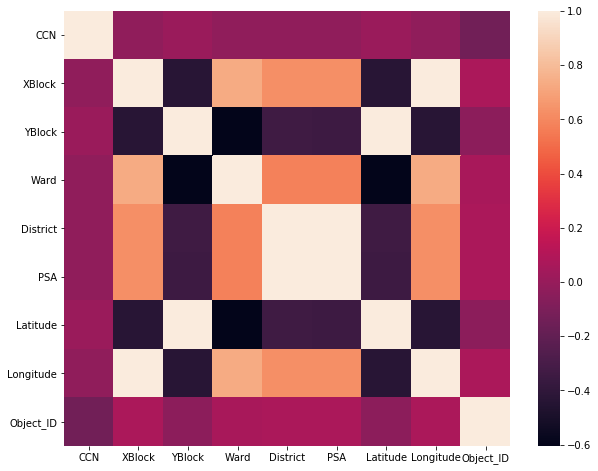

In [50]:
plt.figure(figsize=(10, 8))
sn.heatmap(renamed_df.corr())
plt.savefig('Images/Correlation_HeatMap.png')
plt.show()

# Scatter Plots

As discussed above, scatter plots do not illustrate any meaning correlations

### Function to Create Scatter Plot

In [51]:
def makeScatter(col1, col2, df):  
    plt.figure(figsize=(8, 8))
    plt.scatter(df[col1], df[col2], c="blueviolet", edgecolors="black", alpha=0.35)
    plt.title(f"{col1.title()} vs {col2.title()}")
    plt.xlabel(f"{col1.title()}")
    plt.ylabel(f"{col2.title()}")
    plt.tight_layout
    plt.show()

### Create List of Variables for Scatter Plots

In [52]:
cols = ['CCN', 'XBlock', 'YBlock', 'Ward', 'District', 'PSA', 'Census_Trac',
       'Latitude', 'Longitude', 'Object_ID']

### Create Scatter Plots for Census Trac

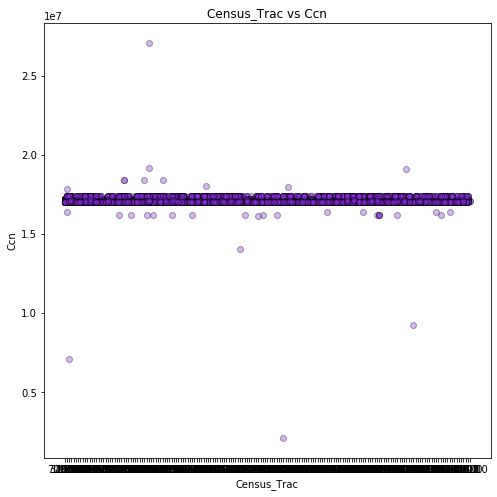

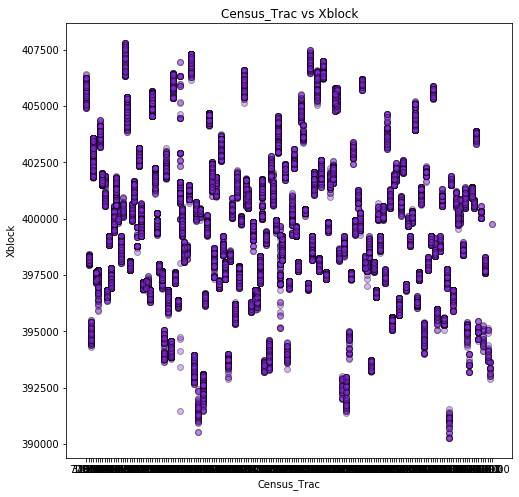

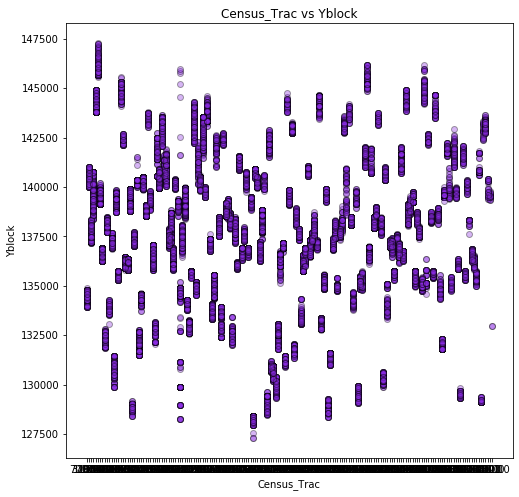

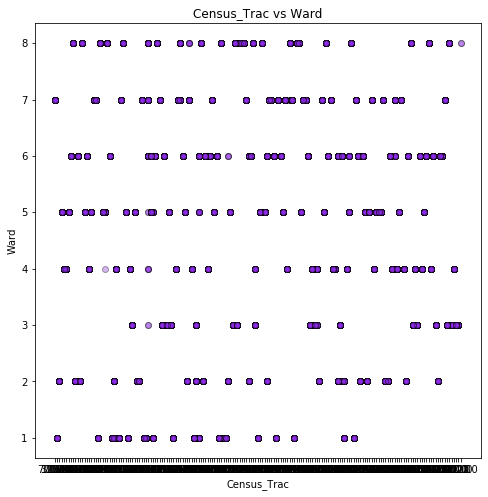

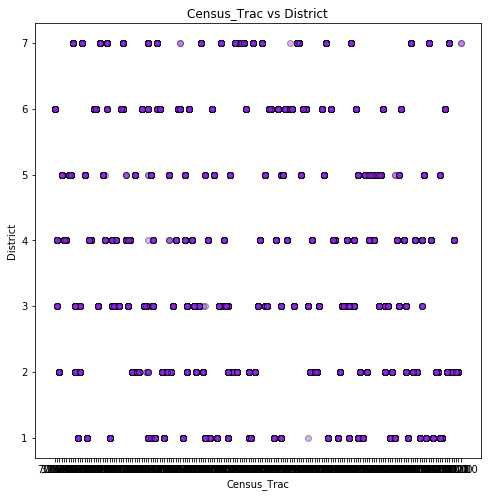

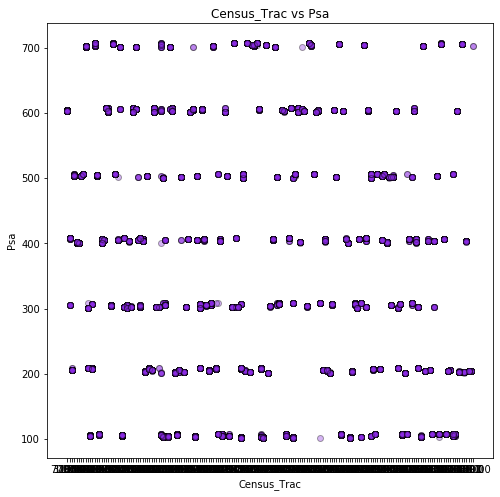

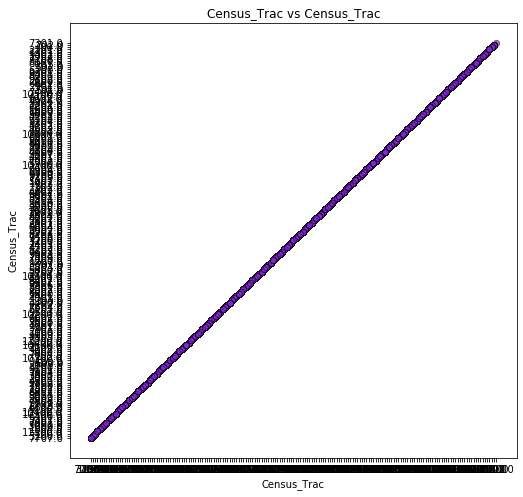

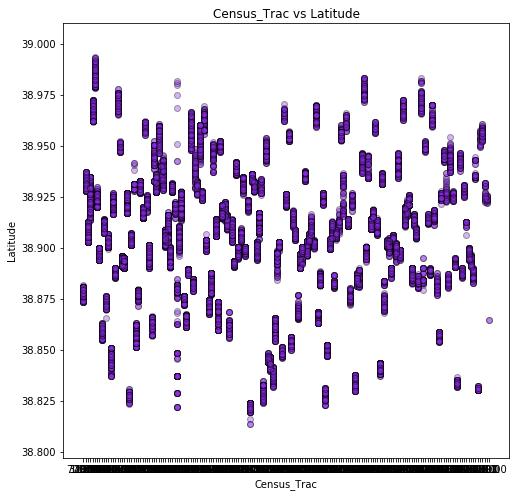

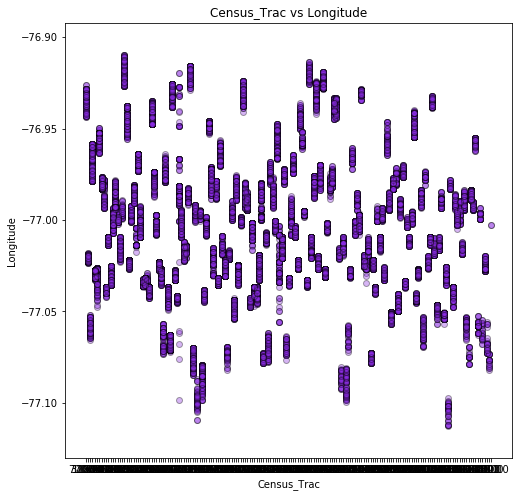

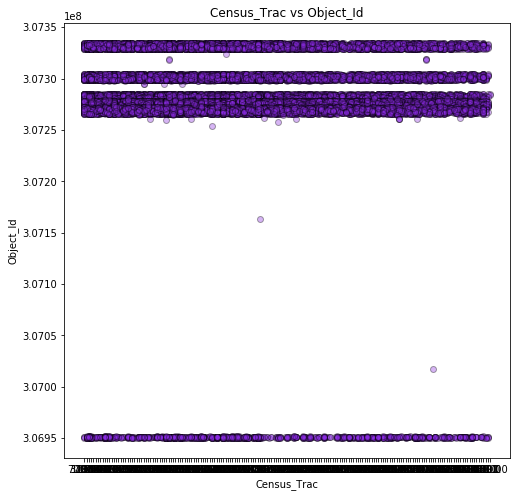

In [53]:
for col in cols:
    makeScatter("Census_Trac", col, renamed_df)

# Chisquared Analysis

In [54]:
rr_df = renamed_df.groupby(renamed_df.Census_Trac).count()['CCN']
rr_df

sub_df = pd.DataFrame(rr_df)
sub_df.sort_values('CCN', ascending=False, inplace=True)
sub_df = sub_df.head(10)
sub_df

CCN
Census_Trac      
5800.0       1053
4400.0        870
10700.0       659
10600.0       629
11100.0       626
202.0         603
9102.0        577
9603.0        510
3000.0        459
5201.0        446

In [55]:
(sub_df['CCN'].sum())/10

643.2

In [56]:
sub_df["Expected"]=643.2

In [57]:
chisquare(sub_df['CCN'],sub_df['Expected'])

Power_divergenceResult(statistic=492.35012437810934, pvalue=2.4970783146911526e-100)

In [58]:
new_list =[1000, 850, 650, 630, 630, 600, 550, 500, 450, 450]
sub_df['Expected']= new_list
sub_df

CCN  Expected
Census_Trac                
5800.0       1053      1000
4400.0        870       850
10700.0       659       650
10600.0       629       630
11100.0       626       630
202.0         603       600
9102.0        577       550
9603.0        510       500
3000.0        459       450
5201.0        446       450

In [59]:
chisquare(sub_df['CCN'],sub_df['Expected'])

Power_divergenceResult(statistic=5.187197847903731, pvalue=0.8176938877718074)